# Neuroimaging Connectomics 02: Anatomical Connectivity 

***Dr. John D. Griffiths***

*KCNI Summer School 2021*

---

In the previous session we looked closely at the two basic building blocks of neuroimaging connectomics: *3D image volumes* and *geodesic surface meshes*. We also learned about brain regions and brain parcellations.  

In this session we will put these components together as we learn about estimation of anatomical connectivity using diffusion-weighted MRI tractography. 

We will:

- Run a quick whole-brain deterministic tractography reconstruction
- Look briefly at the tractography streamlines to understand better what these kooky things are
- Compute an anatomical 'connectome' (connectivity matrix) by combining tractography with a grey matter parcellation volume
- Inspect some of the features of this connectivity matrix


Kudos to the excellent dipy software, and in particular to the [dipy connectivity tutorial](https://www.dipy.org/documentation/1.3.0./_downloads/55176aa19067e5b2fb61cd4c2ae26478/streamline_tools.py) on which the following is largely based. 



## Setup

In [ ]:
# If running in google colab: uncomment these lines to install some packages:

#!pip install dipy nilearn 

     |████████████████████████████████| 7.0MB 7.7MB/s 
     |████████████████████████████████| 4.9MB 32.8MB/s 
     |████████████████████████████████| 7.7MB 19.0MB/s 


Importage:

In [ ]:
# Generic stuff
import os,sys,glob,numpy as np,pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime


# Neuroimaging I/O and Viz stuff
import nibabel as nib
from nilearn.plotting import (plot_anat,plot_roi,plot_stat_map,plot_glass_brain,
                              plot_surf,plot_surf_stat_map,plot_surf_roi,
                              plot_connectome,plot_connectome_strength,
                              find_parcellation_cut_coords)

from nilearn.image import index_img


# Dipy stuff
from scipy.ndimage.morphology import binary_dilation
from dipy.core.gradients import gradient_table
from dipy.data import get_fnames
from dipy.io.gradients import read_bvals_bvecs
from dipy.io.image import load_nifti_data, load_nifti, save_nifti
from dipy.direction import peaks
from dipy.reconst import shm
from dipy.tracking import utils
from dipy.tracking.local_tracking import LocalTracking
from dipy.tracking.stopping_criterion import BinaryStoppingCriterion
from dipy.tracking.streamline import Streamlines,set_number_of_points
from dipy.tracking.distances import approx_polygon_track
from dipy.io.stateful_tractogram import Space, StatefulTractogram
from dipy.io.streamline import save_trk


In [ ]:
# For checking run duration:
start = datetime.now()

## Grab the Data

In [ ]:
# If the data isn't yet downloaded, the following lines will quickly 
# fetch it from a cloud location. 
# If it has already been downloaded, they will instantaneously 
# grab the file paths

hardi_fname, hardi_bval_fname, hardi_bvec_fname = get_fnames('stanford_hardi')
aparc_fname = get_fnames('stanford_labels')
t1_fname = get_fnames('stanford_t1')

By default, the files get stored in a `.dipy` folder in $HOME:

In [ ]:
hardi_fname

'/root/.dipy/stanford_hardi/HARDI150.nii.gz'

In [ ]:
t1_fname

'/root/.dipy/stanford_hardi/t1.nii.gz'

In [ ]:
aparc_fname

'/root/.dipy/stanford_hardi/aparc-reduced.nii.gz'

## Load the data

In this tutorial we are using just four files:

- T1-weighted MRI image (3D nifti volume)
- Freesurfer 'aparc' parcellation image (3D nifti volume)
- Diffusion-weighted data (4D nifti volume)
- Diffusion gradient table (i.e. bvals and bvecs; a short list of numbers)


Let's load them in and take a look.

In [ ]:
hardi_img = nib.load(hardi_fname)
hardi_data = hdardi_img.get_data()

In [ ]:
t1_img = nib.load(t1_fname)
t1_data = t1_img.get_data()

In [ ]:
aparc_img = nib.load(aparc_fname)
aparc_dat = aparc_img.get_data()
labels = aparc_dat

In [ ]:
bvals, bvecs = read_bvals_bvecs(hardi_bval_fname, hardi_bvec_fname)
gtab = gradient_table(bvals, bvecs)

The T1 and the parcellation volume are pretty easy to understand and should be somewhat familiar by now:

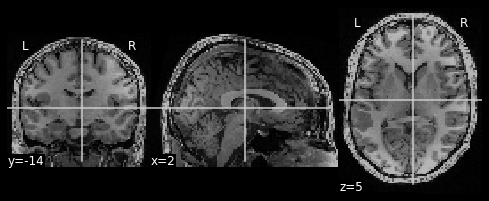

In [ ]:
disp = plot_anat(t1_img);

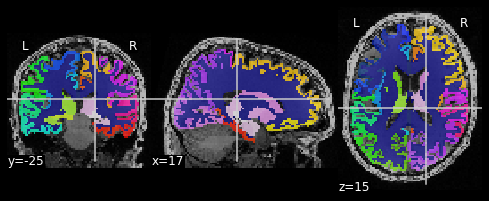

In [ ]:
disp = plot_roi(aparc_img, bg_img=t1_img);

We do also have a text list of the regions in this parcellation

In [ ]:
!cat ~/.dipy/stanford_hardi/label_info.txt

new label, freesurfef label, freesurfer name
1, 2, "Left-Cerebral-White-Matter"
1, 41, "Right-Cerebral-White-Matter"
1, 77, "WM-hypointensities"
1, 85, "Optic-Chiasm"
1, 1004, "ctx-lh-corpuscallosum"
1, 2004, "ctx-rh-corpuscallosum"
2, 251, "CC_Posterior"
2, 252, "CC_Mid_Posterior"
2, 253, "CC_Central"
2, 254, "CC_Mid_Anterior"
2, 255, "CC_Anterior"
3, 1032, "ctx-lh-frontalpole"
4, 1014, "ctx-lh-medialorbitofrontal"
5, 1012, "ctx-lh-lateralorbitofrontal"
6, 1019, "ctx-lh-parsorbitalis"
7, 1020, "ctx-lh-parstriangularis"
8, 1018, "ctx-lh-parsopercularis"
9, 1027, "ctx-lh-rostralmiddlefrontal"
10, 1003, "ctx-lh-caudalmiddlefrontal"
11, 1028, "ctx-lh-superiorfrontal"
12, 1024, "ctx-lh-precentral"
13, 1017, "ctx-lh-paracentral"
14, 1035, "ctx-lh-insula"
15, 1026, "ctx-lh-rostralanteriorcingulate"
16, 1002, "ctx-lh-caudalanteriorcingulate"
17, 1023, "ctx-lh-posteriorcingulate"
18, 1010, "ctx-lh-isthmuscingulate"
19, 1006, "ctx-lh-entorhinal"
20, 1007, "ctx-lh-fusiform"
21, 1016, "ctx-lh-par

The diffusion data is a tad more complex. It consists of a series of 3D nifti volumes, one for each diffusion gradient orientation and weighting. 

We won't be going into the physics of diffusion MRI here in any detail, but a few brief comments for those with some familiarity:

The bvals give the gradient strengths for each volume: 

In [ ]:
bvals

array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
       2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
       2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
       2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
       2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
       2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
       2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
       2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
       2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
       2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
       2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
       2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
       2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
       2000., 2000.,

The bvecs give the gradient orientations

In [ ]:
bvecs[50:60]

array([[-0.26719  ,  0.41599  , -0.86923  ],
       [-0.26594  , -0.96358  ,  0.027981 ],
       [-0.21274  , -0.81226  , -0.54311  ],
       [ 0.83845  , -0.12171  , -0.53121  ],
       [-0.1975   , -0.21432  , -0.95659  ],
       [ 0.51026  , -0.81467  ,  0.27558  ],
       [-0.50455  ,  0.7968   ,  0.33248  ],
       [-0.05039  ,  0.99871  ,  0.0054406],
       [ 0.98875  ,  0.1177   , -0.09229  ],
       [ 0.71962  ,  0.4507   ,  0.52821  ]])

These gradient orientations are 3D vectors that define the surface of a sphere or 'shell' in 'B space'

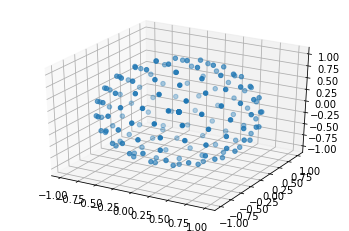

In [ ]:
fig, ax = plt.subplots(subplot_kw={'projection': '3d'})

x,y,z = bvecs.T
ax.scatter(x,y,z)

Because there is just one non-zero bvalue in the bvals list above (2000), this is known as a 'single shell' acquisition. 

As we said, the diffusion volume is a 4D nifti image. The 4th dimension corresponds to the 160 gradient directions

In [ ]:
bvals.shape

(160,)

In [ ]:
hardi_img.shape

(81, 106, 76, 160)

We can, if we like, look at each of these 160 volumes individually...

In [ ]:
hardi_vol3 = index_img(hardi_img,3) 
hardi_vol30 = index_img(hardi_img,30)
hardi_vol40 = index_img(hardi_img,40)

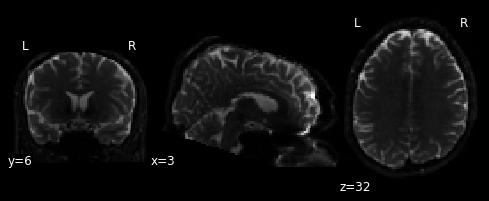

In [ ]:
plot_anat(hardi_vol3, dim=-1, draw_cross=False)

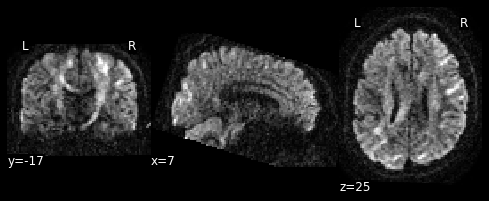

In [ ]:
plot_anat(hardi_vol30, dim=-1, draw_cross=False)

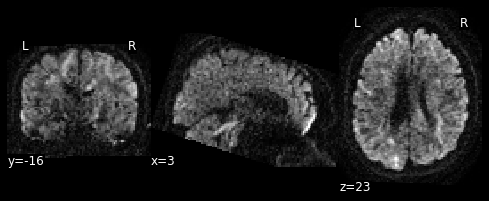

In [ ]:
plot_anat(hardi_vol40, dim=-1, draw_cross=False)

...however in general eyeballing individual diffusion volumes isn't particularly informative, but can be important for checking data quality etc.

## DWI Processing and Streamline Generation

Now we've taken looked at the raw(ish) data, we will get down to business running tractography and creating our anatomical connectomes. 

First we need to create a mask defining all the voxels in the volume that correspond to white matter

In [ ]:
white_matter = binary_dilation((labels == 1) | (labels == 2))
white_matter

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal

Now we hand the white matter mask to a core dipy function that will fit the local diffusion model at each voxel. 

Again, we won't be going into the MR physics in this tutorial. 

But in a nutshell: 

This function is using the 160 diffusion weighting values at each voxel (corresponding to the orientations defined from the sphere plot above) to estimate the principal direction(s) of water diffusion (called an 'orientational distribution function' or ODF). 

In [ ]:
csamodel = shm.CsaOdfModel(gtab, 6)
csapeaks = peaks.peaks_from_model(model=csamodel,
                                  data=data,
                                  sphere=peaks.default_sphere,
                                  relative_peak_threshold=.8,
                                  min_separation_angle=45,
                                  mask=white_matter)

One we have the ODF estimates at each voxel, we can then use this to thread 'streamlines' through the entire diffusion volume, reconstructing the directions of large white matter fibre bundles. 

Whilst state-of-the-art tractography streamline reconstructions are a bit more involved and take a little longer to run, we can get a very good very quick deterministic reconstruction for this dataset in about 20 seconds. 

In [ ]:
%%time
affine = np.eye(4)
seeds = utils.seeds_from_mask(white_matter, affine, density=1)
stopping_criterion = BinaryStoppingCriterion(white_matter)

streamline_generator = LocalTracking(csapeaks, stopping_criterion, seeds,
                                     affine=affine, step_size=0.5)
streamlines = Streamlines(streamline_generator)

CPU times: user 17.8 s, sys: 572 ms, total: 18.3 s
Wall time: 18.2 s


Ok, now let's take some time to take a look at what we've got with this streamline reconstruction:

We'll start at a 'zoomed out' level, and then 'zoom in'. 

One good way of quickly visualizing the streamlines is to convert into an image: 

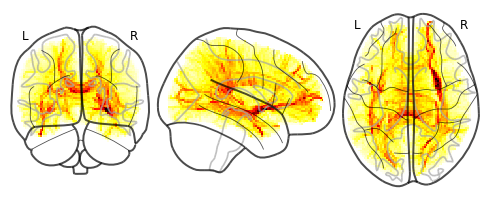

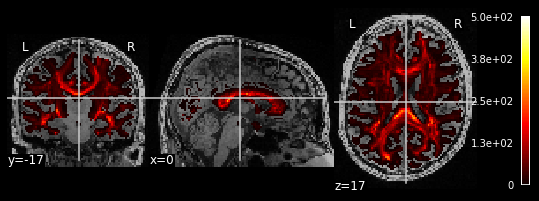

In [ ]:
streamlines_dat = utils.density_map(streamlines, affine, shape)
streamlines_img = nib.Nifti1Image(streamlines_dat,affine=hardi_img.affine)

disp = plot_glass_brain(streamlines_img);
disp = plot_stat_map(streamlines_img,bg_img=t1_img)#,threshold=0)

This is the whole brain. We can also select a sub-set of the streamlines to look at. 

Here we do that using a corpus callosum slice. 

First create the streamline subset:

In [ ]:
cc_slice_dat = labels == 2
cc_streamlines = utils.target(streamlines, affine, cc_slice_dat)
cc_streamlines = Streamlines(cc_streamlines)

other_streamlines = utils.target(streamlines, affine, cc_slice_dat,
                                 include=False)
other_streamlines = Streamlines(other_streamlines)
assert len(other_streamlines) + len(cc_streamlines) == len(streamlines)

Now convert to an image and plot, same as above. 

Here we're also adding an outline contour to the image of the corpus callosum slice that we used to define this streamline set:

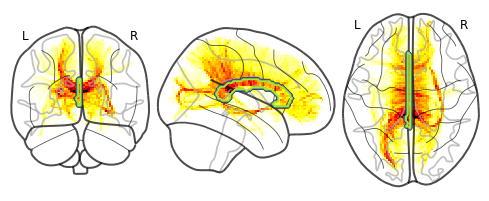

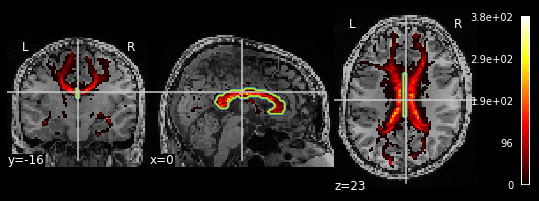

In [ ]:
cc_slice_img = nib.Nifti1Image(cc_slice.astype(float),affine=hardi_img.affine)

cc_streamlines_dat = utils.density_map(cc_streamlines, affine, shape)
cc_streamlines_img = nib.Nifti1Image(cc_streamlines_dat,affine=hardi_img.affine)

disp = plot_glass_brain(cc_streamlines_img);
disp.add_contours(cc_slice_img);


disp = plot_stat_map(cc_streamlines_img,bg_img=t1_img)#,threshold=0)
disp.add_contours(cc_slice_img);

Now let's zoom in a bit further, so we're really clear what these 'streamline' things are. 

First, it's convenient for visualization purposes to downsample the streamlines:

In [ ]:
cc_streamlines_ds = [approx_polygon_track(s,0.9) for s in cc_streamlines]

In [ ]:
[s.shape[0] for s in cc_streamlines[:10]]

[133, 93, 93, 85, 88, 84, 61, 62, 88, 120]

In [ ]:
[s.shape[0] for s in cc_streamlines_ds[:10]]

[15, 11, 10, 9, 9, 8, 6, 7, 11, 16]

As we can see, here we've taken the number of points in each streamline down by about a factor of 10

The downsampling let's us do a simple scatter plot of the 18000 or so corpus callosum streamlines 

In [ ]:
len(cc_streamlines)

18386

CPU times: user 38.1 s, sys: 930 ms, total: 39 s
Wall time: 38.9 s


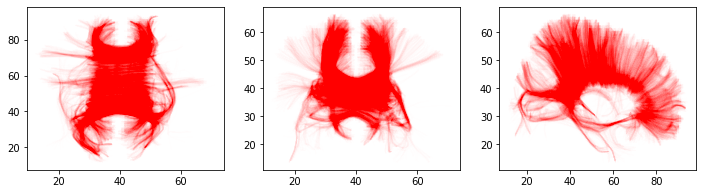

In [ ]:
%%time

fig, ax = plt.subplots(ncols=3, figsize=(12,3))

for s_it,s in enumerate(cc_streamlines_ds):
    
    x,y,z = s.T
    
    a = ax[0]
    a.plot(x,y,c='r',alpha=0.005)
    
    a = ax[1]
    a.plot(x,z,c='r',alpha=0.005)
    
    a = ax[2]
    a.plot(y,z,c='r',alpha=0.005)
      

Again, taking a closer look in this: 

Each of these streamlines is simple a list of x,y,z co-ordinates

CPU times: user 160 ms, sys: 1.59 ms, total: 161 ms
Wall time: 163 ms


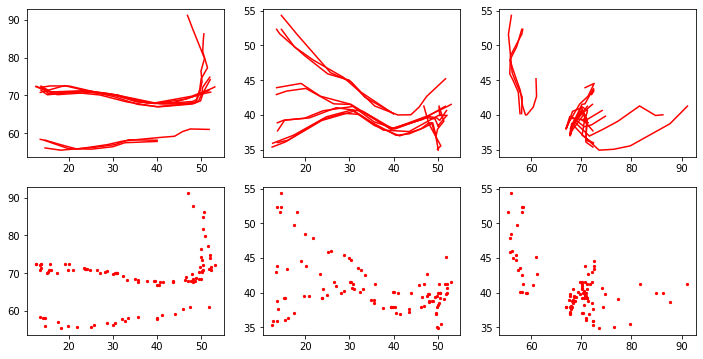

In [ ]:
%%time

fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(12,6))

for s_it,s in enumerate(cc_streamlines_ds[:10]):
    
    x,y,z = s.T
    
    a = ax[0][0]
    a.plot(x,y,c='r')#,alpha=0.1)
    
    a = ax[0][1]
    a.plot(x,z,c='r')#,alpha=0.1)
    
    a = ax[0][2]
    a.plot(y,z,c='r')#,alpha=0.1)


    a = ax[1][0]
    a.scatter(x,y,c='r',s=5)#,alpha=0.1)
    
    a = ax[1][1]
    a.scatter(x,z,c='r',s=5)#,alpha=0.1)
    
    a = ax[1][2]
    a.scatter(y,z,c='r',s=5)#,alpha=0.1)
            

CPU times: user 149 ms, sys: 915 µs, total: 150 ms
Wall time: 150 ms


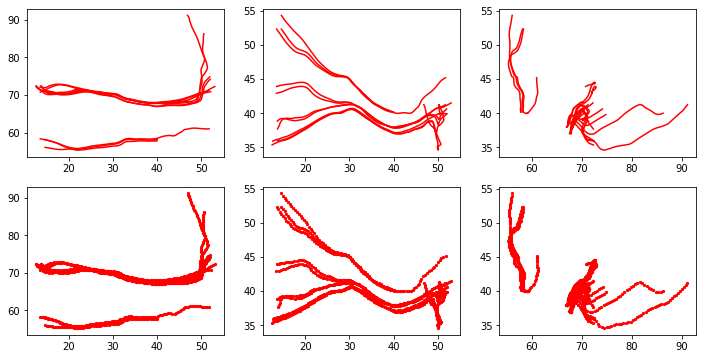

In [ ]:
%%time

fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(12,6))

for s_it,s in enumerate(cc_streamlines[:10]):
    
    x,y,z = s.T
    
    a = ax[0][0]
    a.plot(x,y,c='r')#,alpha=0.1)
    
    a = ax[0][1]
    a.plot(x,z,c='r')#,alpha=0.1)
    
    a = ax[0][2]
    a.plot(y,z,c='r')#,alpha=0.1)


    a = ax[1][0]
    a.scatter(x,y,c='r',s=5)#,alpha=0.1)
    
    a = ax[1][1]
    a.scatter(x,z,c='r',s=5)#,alpha=0.1)
    
    a = ax[1][2]
    a.scatter(y,z,c='r',s=5)#,alpha=0.1)
            

In [ ]:
len(cc_streamlines)

18386

CPU times: user 150 ms, sys: 2.62 ms, total: 152 ms
Wall time: 154 ms


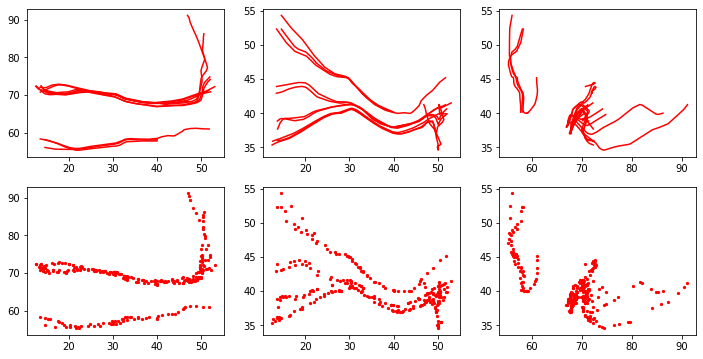

In [ ]:
%%time

fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(12,6))

for s_it,s in enumerate(cc_streamlines_ds[:10]):
    
    x,y,z = s.T
    
    a = ax[0][0]
    a.plot(x,y,c='r')#,alpha=0.1)
    
    a = ax[0][1]
    a.plot(x,z,c='r')#,alpha=0.1)
    
    a = ax[0][2]
    a.plot(y,z,c='r')#,alpha=0.1)


    a = ax[1][0]
    a.scatter(x,y,c='r',s=5)#,alpha=0.1)
    
    a = ax[1][1]
    a.scatter(x,z,c='r',s=5)#,alpha=0.1)
    
    a = ax[1][2]
    a.scatter(y,z,c='r',s=5)#,alpha=0.1)
            

## Compute the connectivity matrix

Now we have our streamlines and our parcellation, it's one short step more to compute our connectivity matrix.

In [ ]:
M, grouping = utils.connectivity_matrix(streamlines, affine,
                                        labels.astype(np.uint8),
                                        return_mapping=True,
                                        mapping_as_streamlines=True)
M[:3, :] = 0
M[:, :3] = 0

In [ ]:
f = '~/.dipy/stanford_hardi/label_info.txt'
df_label_info = pd.read_csv(f)
df_label_info.set_index('new label', inplace=True)
labtxt = df_label_info[' freesurfer name'].loc[3:].values
labtxt = [l.replace(' ', '').replace('"', '') for l in labtxt]

In [ ]:
df_M = pd.DataFrame(M[3:,3:],columns=labtxt,index=labtxt)

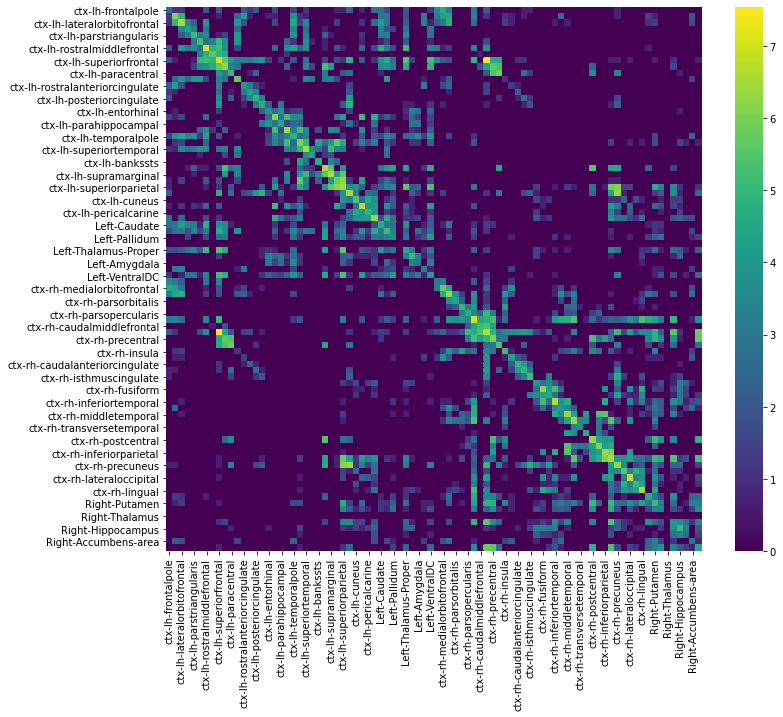

In [ ]:
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(np.log1p(df_M),ax=ax,cmap='viridis')

We can pull out an individual entry in the connectivity and take a look at the corresponding streamline

In [ ]:
grouping.keys()

dict_keys([(8, 54), (1, 8), (1, 9), (1, 1), (2, 12), (1, 12), (0, 9), (0, 12), (1, 10), (12, 54), (0, 1), (1, 2), (0, 8), (0, 34), (34, 52), (0, 10), (36, 87), (2, 8), (23, 87), (0, 20), (1, 52), (23, 52), (1, 81), (1, 39), (1, 23), (0, 45), (12, 55), (1, 24), (1, 30), (0, 36), (24, 81), (24, 52), (39, 81), (1, 74), (1, 31), (9, 52), (39, 74), (23, 81), (1, 36), (1, 84), (24, 85), (45, 84), (1, 88), (1, 55), (1, 14), (1, 54), (9, 54), (33, 76), (1, 33), (24, 74), (33, 84), (0, 74), (33, 64), (0, 52), (0, 35), (1, 62), (0, 81), (39, 52), (1, 82), (74, 79), (1, 35), (38, 52), (0, 0), (1, 67), (1, 42), (2, 14), (2, 9), (31, 81), (1, 34), (34, 82), (1, 32), (32, 76), (36, 79), (1, 79), (1, 76), (24, 88), (41, 88), (38, 81), (0, 55), (1, 38), (34, 81), (31, 82), (1, 77), (0, 31), (31, 84), (36, 85), (74, 84), (30, 74), (1, 64), (74, 85), (1, 41), (74, 76), (1, 85), (0, 42), (1, 43), (0, 30), (5, 48), (34, 74), (31, 52), (31, 85), (35, 85), (35, 79), (36, 76), (36, 84), (34, 77), (35, 77), (

In [ ]:
lr_superiorfrontal_track = grouping[11, 54]

make a slightly artificial visulization just to highlight what this connection is

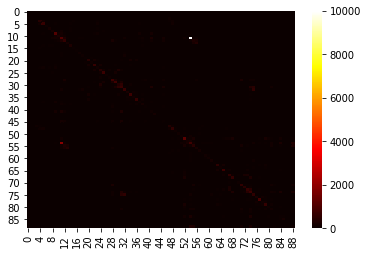

In [ ]:
mat = M.copy()
mat[11,54] = 10000
sns.heatmap(mat,cmap='hot')

Take a look at this streamline as we did previously

In [ ]:
lr_superiorfrontal_track[0][:10,:]

array([[29.62467817, 89.27872393, 39.8226684 ],
       [30.        , 89.        , 40.        ],
       [30.37532183, 88.72127607, 40.1773316 ],
       [30.7692152 , 88.41784229, 40.23001892],
       [30.96451644, 88.03668652, 39.97199236],
       [31.10466259, 87.66716385, 39.66570483],
       [31.1749656 , 87.29202058, 39.342711  ],
       [31.17515581, 86.9160759 , 39.0130664 ],
       [31.11115771, 86.53952426, 38.69040077],
       [31.00876623, 86.1382338 , 38.41025448]])

CPU times: user 162 ms, sys: 0 ns, total: 162 ms
Wall time: 163 ms


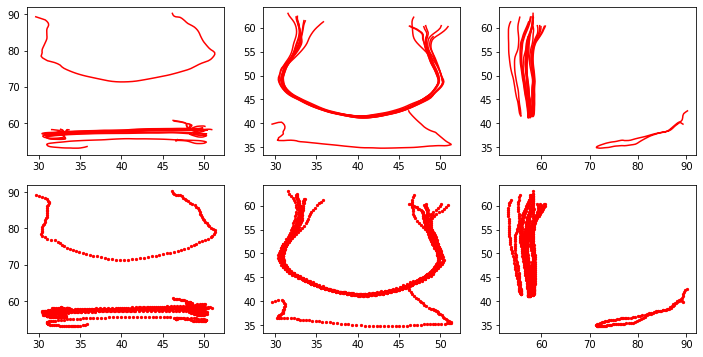

In [ ]:
%%time

fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(12,6))

for s_it,s in enumerate(lr_superiorfrontal_track[:10]):
    
    x,y,z = s.T
    
    a = ax[0][0]
    a.plot(x,y,c='r')#,alpha=0.1)
    
    a = ax[0][1]
    a.plot(x,z,c='r')#,alpha=0.1)
    
    a = ax[0][2]
    a.plot(y,z,c='r')#,alpha=0.1)


    a = ax[1][0]
    a.scatter(x,y,c='r',s=5)#,alpha=0.1)
    
    a = ax[1][1]
    a.scatter(x,z,c='r',s=5)#,alpha=0.1)
    
    a = ax[1][2]
    a.scatter(y,z,c='r',s=5)#,alpha=0.1)
            

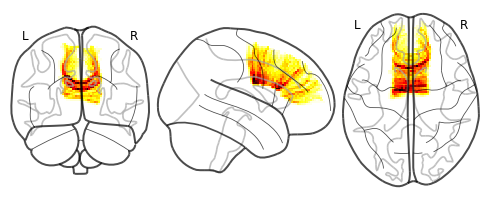

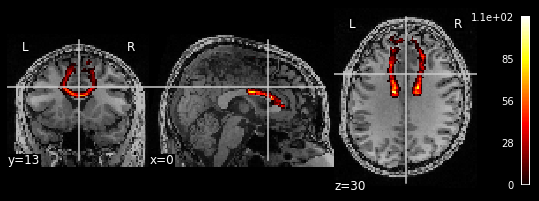

In [ ]:
lr_superiorfrontal_track = grouping[11, 54]
shape = labels.shape
lr_superiorfrontal_dat = utils.density_map(lr_superiorfrontal_track, affine, shape)
lr_superiorfrontal_img = nib.Nifti1Image(lr_superiorfrontal_dat,affine=hardi_img.affine)

disp = plot_glass_brain(lr_superiorfrontal_img);
disp = plot_stat_map(lr_superiorfrontal_img,bg_img=t1_img)#,threshold=0)


Finally, it is sometimes useful to plot our connectomes as graphs in brain space:

In [ ]:
aparc_coords = find_parcellation_cut_coords(labels_img=aparc_img)

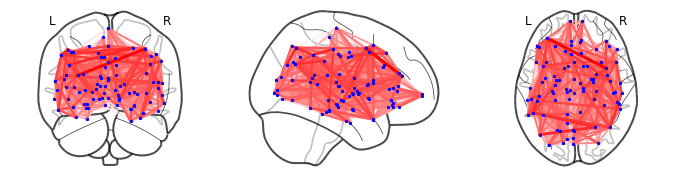

In [ ]:
fig, ax = plt.subplots(figsize=(12,3))

disp = plot_connectome(np.log1p(M[3:,3:]),aparc_coords,figure=fig,axes=ax,
                       black_bg=False,node_size=5,node_color='b')

In [ ]:
M_cc, grouping_cc = utils.connectivity_matrix(cc_streamlines, affine,
                                        labels.astype(np.uint8),
                                        return_mapping=True,
                                        mapping_as_streamlines=True)
M_cc[:3, :] = 0
M_cc[:, :3] = 0

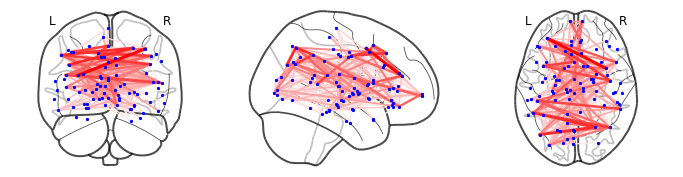

In [ ]:
fig, ax = plt.subplots(figsize=(12,3))

disp = plot_connectome(np.log1p(M_cc[3:,3:]),aparc_coords,figure=fig,axes=ax,
                       black_bg=False,node_size=5,node_color='b')

That concludes our lighting-fast run-through of DWI tractography-based anatomical connectome reconstruction! :)